In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

In [ ]:
!cp -r "/content/drive/My Drive/marble" "marble"

In [ ]:
!ls "/content/marble"

'marble datasets'  'MINST Genetic Algorithm.ipynb'


In [ ]:
# create final dataset.the training  dataset consits of (0.8 * 0.8 * T), the valdation dataset (0.2 * 0.8 * T) and (0.2 * T) testing images.

from tensorflow.keras.layers import  Convolution2D, MaxPooling2D, Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

#count the number of images in respective directory
import fnmatch
print( "Total number of images in CLASS A", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS A"), '*.jpg')));
print( "Total number of images in CLASS B", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS B"), '*.jpg')));
print( "Total number of images in CLASS C", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS C"), '*.jpg')));

Total number of images in CLASS A 164
Total number of images in CLASS B 245
Total number of images in CLASS C 494


In [ ]:
# split dataset into train_test_folder
! pip install python_splitter 
import python_splitter
python_splitter.split_from_folder("/content/marble/marble datasets", train=0.64, test=0.16, val=0.2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✅Checking SOURCE directory...
0.64 0.2 0.16
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="Train_Test_Folder/train"
test_dir="Train_Test_Folder/test"

In [ ]:
#train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*")) 
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

3 Classes
576 Train images
181 Test images


In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)


In [ ]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 576 images belonging to 3 classes.
Found 181 images belonging to 3 classes.


In [ ]:
def create_Base_model_from_InceptionV3():
    IMAGE_SIZE = [224, 224]
    model_inceptionV3 = InceptionV3( 
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = IMAGE_SIZE + [3],)
    # We don't need to train existing weights
    for layer in model_inceptionV3.layers:
        layer.trainable = False
    return model_inceptionV3

In [ ]:
inception = create_Base_model_from_InceptionV3();
x = Flatten()(inception.output)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
def create_Base_model_from_VGG16():  
    model = VGG16(
        weights = "imagenet",
        include_top=False, 
        input_shape = (224,224, 3) # goruntu boyutu
        ) 
    for layer in model.layers:
      layer.trainable = False
    return model 

In [ ]:
def add_custom_layers_VGG16():
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model.input, 
        outputs = predictions)
     
  
    return final_model

# add_custom_layers_VGG16().summary()

In [ ]:
def create_Base_model_from_VGG19():  
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (224,224, 3)) # image size
    # don't train existing weights 
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19 
# create_Base_model_from_VGG19().summary()

In [ ]:
def add_custom_layers_vgg19():
    #Adding custom Layers 
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model_vgg19.input, 
        outputs = predictions)
     
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return final_model

# add_custom_layers_vgg19().summary()

In [ ]:
def create_Base_model_from_ResNet50():
    model_resNet50 = ResNet50( 
        weights = "imagenet",# control point from which model is started
        include_top=False,
        pooling='avg',
        input_shape = (224,224, 3))
    # We don't need to train existing weights
    model_resNet50.trainable = False
    return model_resNet50


pretrained_model= create_Base_model_from_ResNet50()
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:

def alexnet():
    #Adding custom Layers 
    # Initializing the CNN
    model = Sequential()
    # Convolution Step 1
    model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))
    # Max Pooling Step 1
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    model.add(BatchNormalization())
    # Convolution Step 2
    model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
    # Max Pooling Step 2
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
    model.add(BatchNormalization())
    # Convolution Step 3
    model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    model.add(BatchNormalization())
    # Convolution Step 4
    model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    model.add(BatchNormalization())
    # Convolution Step 5
    model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))
    # Max Pooling Step 3
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    model.add(BatchNormalization())
    # Flattening Step
    model.add(Flatten())
    # Full Connection Step
    model.add(Dense(units = 4096, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(units = 4096, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(units = 1000, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units = num_classes, activation = 'softmax'))
    
    return model

# add_custom_layers_vgg19().summary()

In [ ]:
# model = add_custom_layers_vgg19()
# model = add_custom_layers()
model = alexnet()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 181 images belonging to 3 classes.


In [ ]:
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)

Found 576 images belonging to 3 classes.


In [ ]:
history = model.fit(
            train_generator,#egitim verileri
            steps_per_epoch=None,
            epochs=2, #use 5 for vgg16
            validation_data=validation_generator,
            validation_steps=None,
            verbose=1,
            callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
            shuffle=True
            )

Epoch 1/2
18/18 [==============================] - 184s 10s/step - loss: 2.5447 - accuracy: 0.5278 - val_loss: 190.7420 - val_accuracy: 0.2707 - lr: 0.0010
Epoch 2/2
18/18 [==============================] - 180s 10s/step - loss: 1.3268 - accuracy: 0.5851 - val_loss: 159.7000 - val_accuracy: 0.2707 - lr: 0.0010


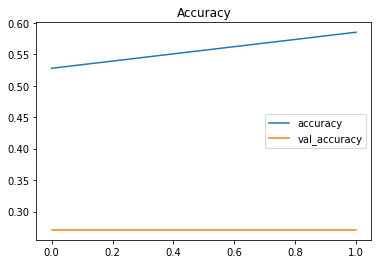

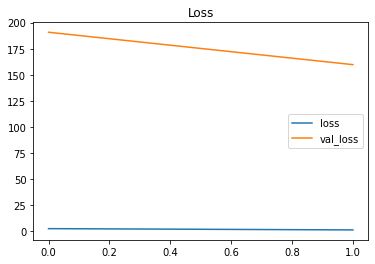

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 31s 5s/step - loss: 160.3827 - accuracy: 0.2707
Test Accuracy: 27.07182466983795


In [ ]:
predicted_classes = model.predict(test_generator)
predicted_classes = np.argmax(predicted_classes, axis=1)

num_classes = 3
train_y=test_generator.classes
target_names = [f"Class {i}" for i in range(num_classes)]

print(classification_report(train_y, predicted_classes, target_names = target_names))

6/6 [==============================] - 19s 3s/step
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        33
     Class 1       0.27      1.00      0.43        49
     Class 2       0.00      0.00      0.00        99

    accuracy                           0.27       181
   macro avg       0.09      0.33      0.14       181
weighted avg       0.07      0.27      0.12       181



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('inception.h5')

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='Train_Test_Folder/val/CLASS A/IMG_20220811_092509.jpg'
model_result = model.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(model_result,axis=1)
print(classes[classresult[0]])